In [ ]:
!pip install transformers==3

     |████████████████████████████████| 757kB 17.9MB/s 
     |████████████████████████████████| 3.0MB 46.6MB/s 
     |████████████████████████████████| 1.2MB 51.9MB/s 
     |████████████████████████████████| 901kB 50.6MB/s 


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from tqdm import tqdm


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 23
np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip freeze > requirements.txt

In [ ]:
data_train = pd.read_csv('/content/full_eng.csv')
data_train.head()

Unnamed: 0                                               Text  label
0           0                                          Next part      0
1           1                 Iii8mllllllm\nMdxfvb8o90lplppi0005      0
2           2  🤣🤣😂😂🤣🤣🤣😂osm vedio ....keep it up...make more v...      0
3           3  What the fuck was this? I respect shwetabh and...      0
4           4  Concerned authorities should bring arundathi R...      0

In [ ]:
data_test = pd.read_csv('/content/test.csv')

In [ ]:
#data.drop(['ID','Sub-task B'], axis=1, inplace=True)
data_test.drop(['ID','Sub-task B'], axis=1, inplace=True)




• Overtly Aggressive (OAG),
• Covertly Aggressive (CAG),
• Non-aggressive (NAG)

In [ ]:
#NAG_train = data[(data['Sub-task A']=='NAG')]
#OAG_train = data[(data['Sub-task A']=='CAG')]
#CAG_train = data[(data['Sub-task A']=='OAG')]

In [ ]:
NAG_test = data_test[(data_test['Sub-task A']=='NAG')]
OAG_test= data_test[(data_test['Sub-task A']=='CAG')]
CAG_test = data_test[(data_test['Sub-task A']=='OAG')]

In [ ]:
import warnings as wrn
wrn.filterwarnings('ignore')

#NAG_train["Sub-task A"] = 0 
#negatives_test["Sentiment"] = 0

#OAG_train["Sub-task A"] = 1
#positives_test["Sentiment"] = 2

#CAG_train["Sub-task A"] = 2
#neutrals_test["Sentiment"] = 1

#NAG_train.head()

In [ ]:
import warnings as wrn
wrn.filterwarnings('ignore')

NAG_test["Sub-task A"] = 0 
#negatives_test["Sentiment"] = 0

OAG_test["Sub-task A"] = 1
#positives_test["Sentiment"] = 2

CAG_test["Sub-task A"] = 2
#neutrals_test["Sentiment"] = 1

NAG_test.head()

Text  Sub-task A
0        U deserve more subscribers. U really great.           0
1                                     Nice video....           0
2  sorry if i bother somebody.. iam a defence asp...           0
3  Joker was amazing....it was not glamorised !.....           0
4                                          Nice baro           0

In [ ]:
#data_train = pd.concat([NAG_train,
#                  OAG_train,
#                  CAG_train
#                 ],axis=0)
#
#data_train.reset_index(inplace=True)

In [ ]:
data_test = pd.concat([NAG_test,
                  OAG_test,
                  CAG_test
                 ],axis=0)

data_test.reset_index(inplace=True)

In [ ]:

data_test = data_test.rename(columns = {'Sub-task A': 'label'}, inplace = False)

In [ ]:
#data_train = data_train.rename(columns = {'Sub-task A': 'label'}, inplace = False)
#data_test = data_test.rename(columns = {'Sub-task A': 'label'}, inplace = False)


In [ ]:
train, test = train_test_split(data_test, test_size=0.1, random_state=23)
train, val = train_test_split(data_train, test_size=0.3,random_state=23)

In [ ]:
train

Unnamed: 0                                               Text  label
637          794                           I M ONLY BISEXUAL HERE??      0
7994         343                                 Pagli sales seller      2
346          430  I missed you omggg, thank you for educating us...      0
638          795                                  **Flimcompanion**      0
4321          58                       feminists = modern 細 facists      1
...          ...                                                ...    ...
2998        3783  Months gone ! And i still get full satisfactio...      0
1993        2537                                         100% right      0
1064        1351                                       Nice Actress      0
4838          75      thank you, grandpa. as you very much grandpa.      1
595          741                 hahah hahha yaar so good...😀😀😀😂😂😂😂      0

[5720 rows x 3 columns]

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Sample Test

In [ ]:
sample_txt = 'I am gay boy plese love me any hot top i love hot boys'

tokens = tokenizer.tokenize(sample_txt)

token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: I am gay boy plese love me any hot top i love hot boys
   Tokens: ['I', 'am', 'gay', 'boy', 'p', '##les', '##e', 'love', 'me', 'any', 'hot', 'top', 'i', 'love', 'hot', 'boys']
Token IDs: [146, 1821, 6463, 2298, 185, 2897, 1162, 1567, 1143, 1251, 2633, 1499, 178, 1567, 2633, 3287]


In [ ]:
tokenizer.special_tokens_map

{'cls_token': '[CLS]',
 'mask_token': '[MASK]',
 'pad_token': '[PAD]',
 'sep_token': '[SEP]',
 'unk_token': '[UNK]'}

In [ ]:
class_names = ['NAG', 'OAG', 'CAG']

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101,  146, 1821, 6463, 2298,  185, 2897, 1162, 1567, 1143, 1251, 2633,
        1499,  178, 1567, 2633, 3287,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
class GPDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(
  data_train,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((7354, 3), (409, 3), (409, 3))

In [ ]:
MAX_LEN = 160

In [ ]:
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.Text.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(data_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [ ]:
last_hidden_state.shape
torch.Size([1, 32, 768])

torch.Size([1, 32, 768])

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
class Classifier(nn.Module):
  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = Classifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5460, 0.1775, 0.2764],
        [0.4597, 0.2329, 0.3074],
        [0.6521, 0.1559, 0.1920],
        [0.5220, 0.2776, 0.2004],
        [0.5951, 0.2211, 0.1838],
        [0.2941, 0.2079, 0.4980],
        [0.5039, 0.2097, 0.2864],
        [0.4258, 0.2837, 0.2904],
        [0.4544, 0.3142, 0.2314],
        [0.6559, 0.1661, 0.1780],
        [0.6100, 0.2026, 0.1874],
        [0.3935, 0.4248, 0.1817],
        [0.4802, 0.1523, 0.3675],
        [0.2924, 0.3842, 0.3233],
        [0.4450, 0.3198, 0.2352],
        [0.3854, 0.3778, 0.2368]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
EPOCHS = 30
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/30
----------
Train loss 0.8230764407826506 accuracy 0.6053848245852597
Val   loss 0.6831529759443723 accuracy 0.7163814180929096

Epoch 2/30
----------
Train loss 0.5162464193189922 accuracy 0.7748164264345934
Val   loss 0.6143508994808564 accuracy 0.7750611246943765

Epoch 3/30
----------
Train loss 0.27255124668793185 accuracy 0.8974707642099538
Val   loss 0.7461135811530627 accuracy 0.7701711491442543

Epoch 4/30
----------
Train loss 0.1477336450236971 accuracy 0.9556703834647811
Val   loss 0.8661308936201609 accuracy 0.7946210268948655

Epoch 5/30
----------
Train loss 0.08448025896599891 accuracy 0.9781071525700299
Val   loss 1.1168136108474125 accuracy 0.8068459657701711

Epoch 6/30
----------
Train loss 0.05473066512846423 accuracy 0.9858580364427522
Val   loss 1.1955809268099704 accuracy 0.8092909535452323

Epoch 7/30
----------
Train loss 0.02716383585909131 accuracy 0.9919771552896383
Val   loss 1.3407682315088236 accuracy 0.8092909535452323

Epoch 8/30
----------
T

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


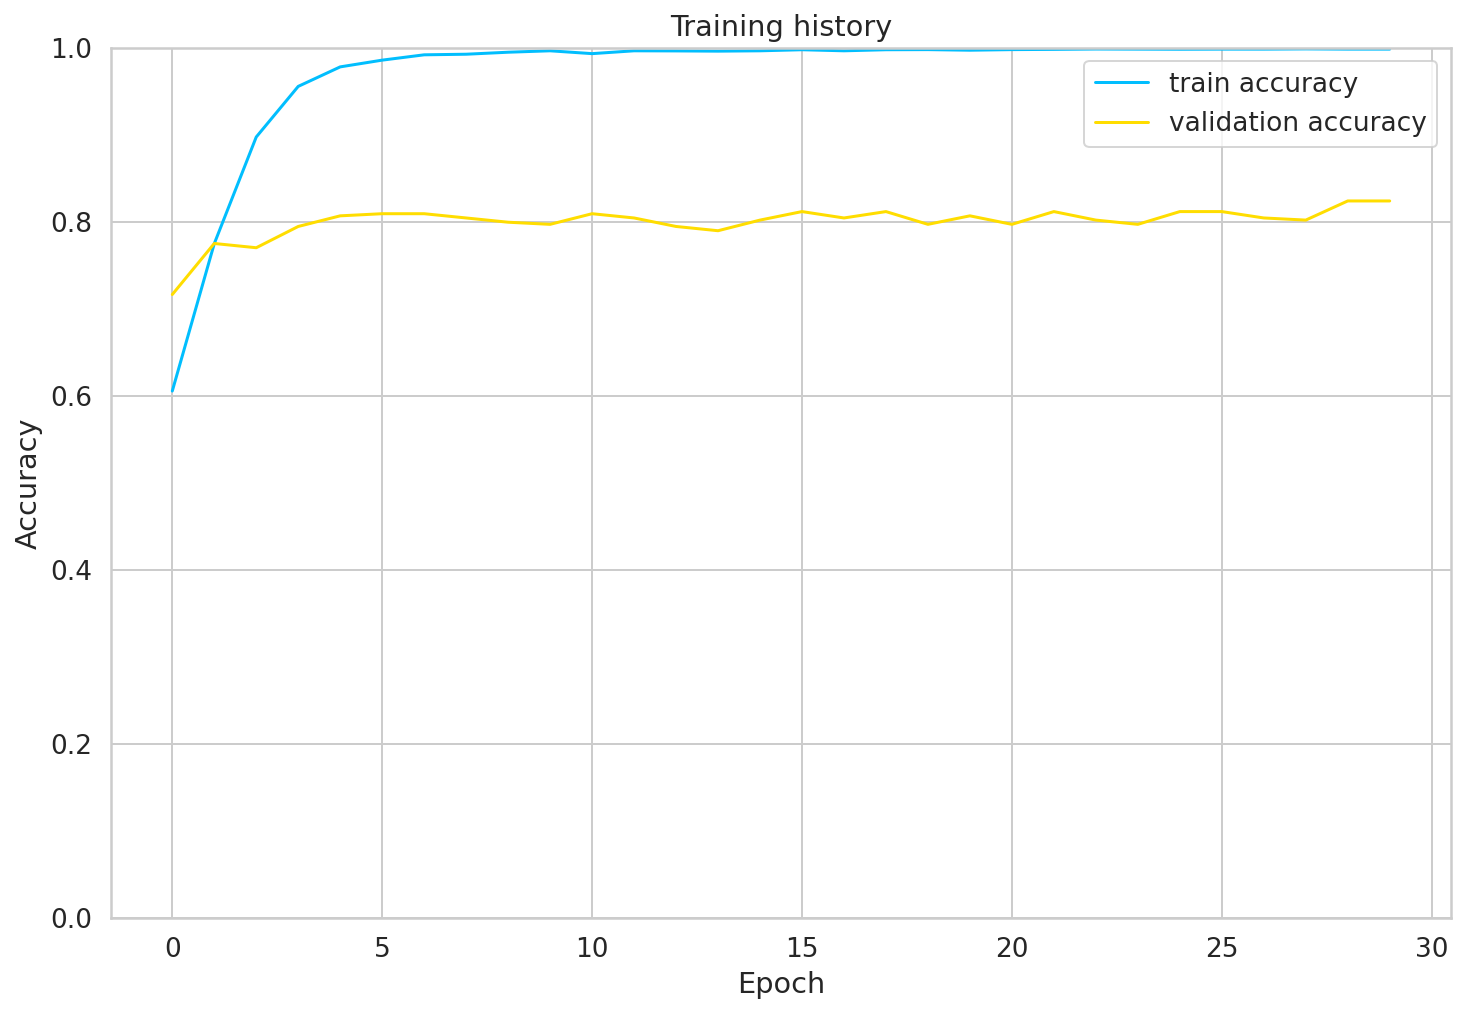

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  aggr_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      aggr_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return aggr_texts, predictions, prediction_probs, real_values

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         NAG       0.89      0.83      0.86       836
         OAG       0.31      0.42      0.36       117
         CAG       0.47      0.52      0.50       113

    accuracy                           0.75      1066
   macro avg       0.56      0.59      0.57      1066
weighted avg       0.78      0.75      0.77      1066



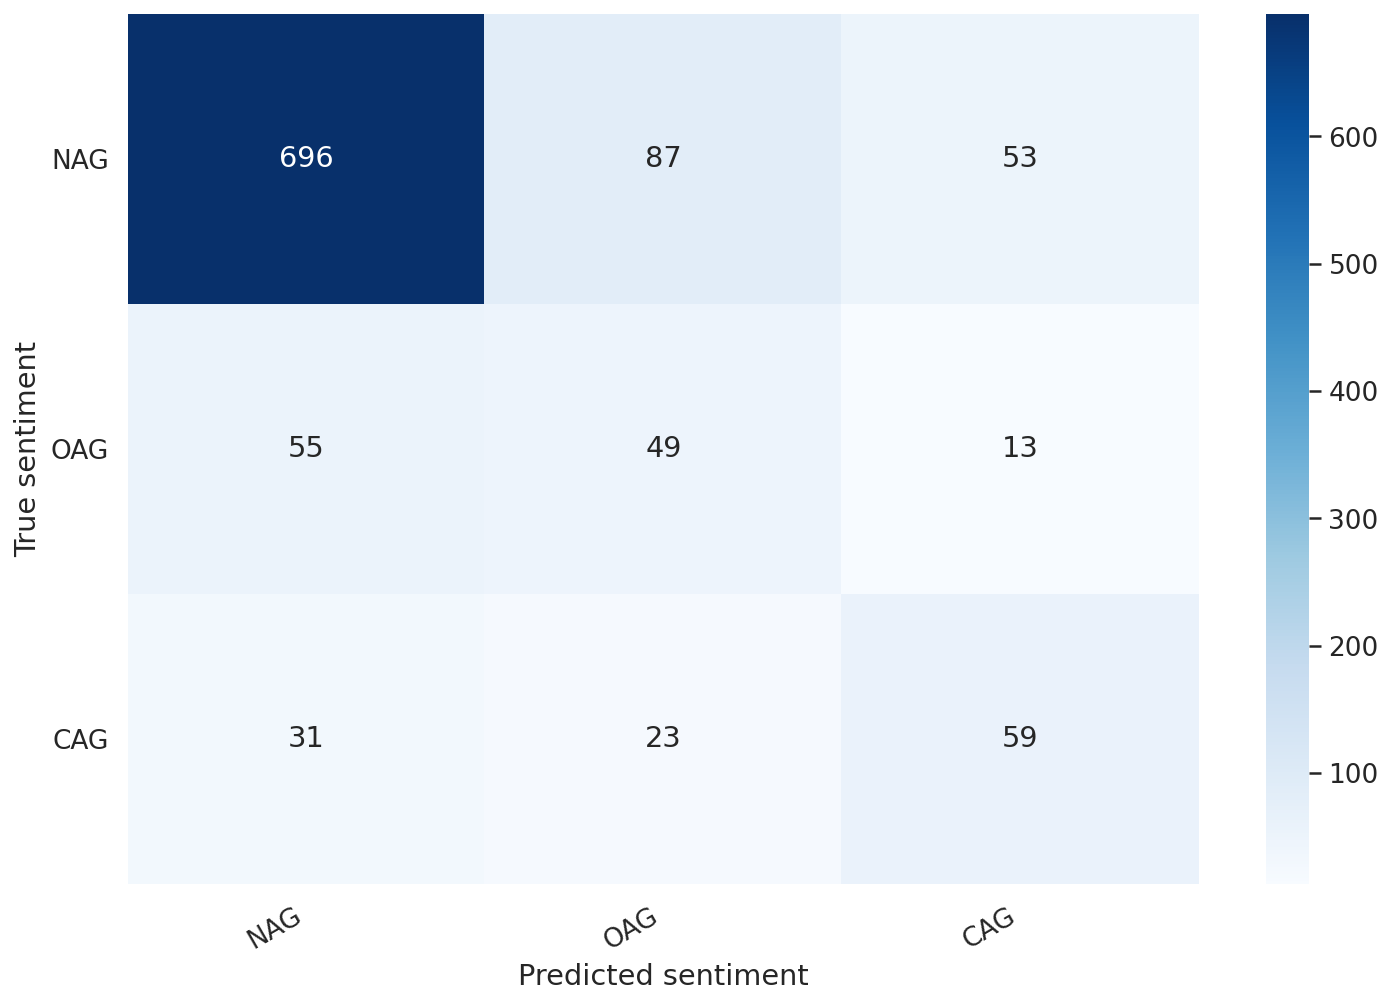

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True aggression')
  plt.xlabel('Predicted aggression');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

sorry if i bother somebody.. iam a defence aspirant..   and i think
that homosexual shouldn't be allowed to join army as a general duty
personnel as we know that a different kind of atmosphere is there..
they have a very harsh routine there... abusing,hard workouts
unbearable pain unbearable punishment and manhandling for severe
mistakes(mainly in probation period) is normal... when such type of
thing will happen to them they could get a feeling of
discrimination(which is clearly not) however they can join clerical
medical supply signal corps as upper mention hardness is of less
magnitude there...

True sentiment: NAG


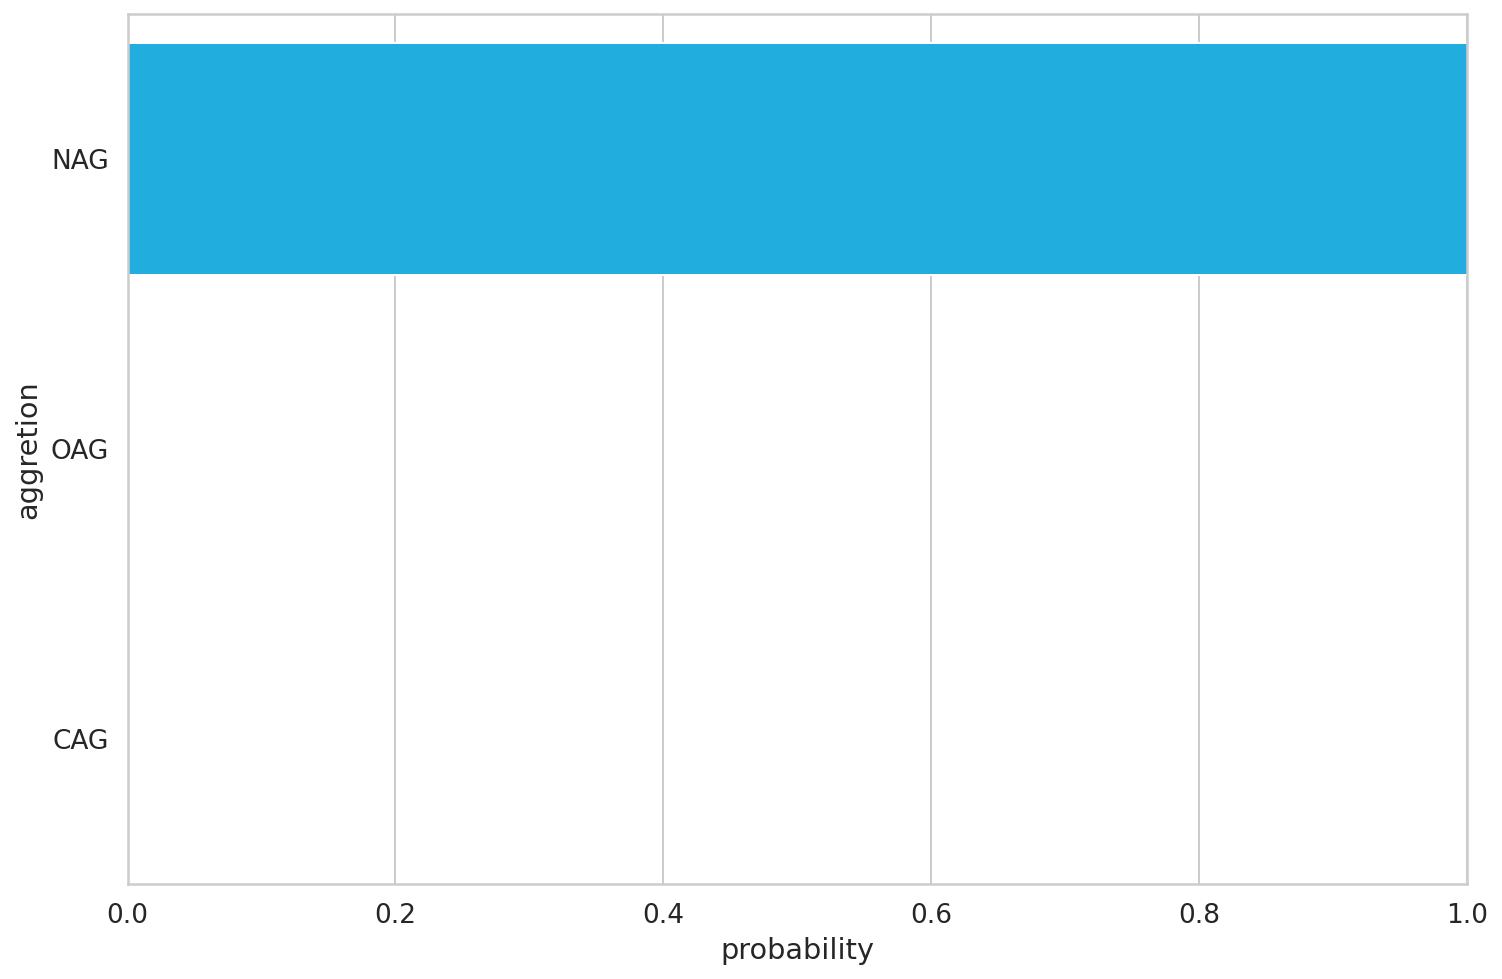

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('aggretion')
plt.xlabel('probability')
plt.xlim([0, 1]);

Predicting on raw text

In [ ]:
review_text = "he does not deserve any education!"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')


Review text: he does not deserve any education!
Sentiment  : OAG
